In [1]:
import pandas as pd
import string
import os
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import time
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import folium
from itertools import cycle, islice
from pandas import options
import warnings
import pickle
import re
import nltk
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from matplotlib.pyplot import figure
from nltk.corpus import stopwords 
import nltk


nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## *Step 1*: Load the data of preprocessing Notebook

In [3]:
x_train_file = open('/content/drive/My Drive/X_train.pkl', 'rb')
X_train = pickle.load(x_train_file)

x_test_file = open('/content/drive/My Drive/X_test.pkl', 'rb')
X_test = pickle.load(x_test_file)

y_train_file = open('/content/drive/My Drive/Y_train.pkl', 'rb')
Y_train = pickle.load(y_train_file)

y_test_file = open('/content/drive/My Drive/Y_test.pkl', 'rb')
Y_test = pickle.load(y_test_file)

x_val_file = open('/content/drive/My Drive/X_val.pkl', 'rb')
X_val = pickle.load(x_val_file)

y_val_file = open('/content/drive/My Drive/Y_val.pkl', 'rb')
Y_val = pickle.load(y_val_file)

## *Step 2*: Vectorization with TF-IDF

Here I select to have 1000 dimensions, so as to get the most information I could have without memory crashed. If I take less features, the score wasn't so good and if I take more features, I have memory crashed.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

train = X_train['text'].tolist()
val = X_val['text'].to_list()
test = X_test['text'].tolist()
STOPWORDS = set(stopwords.words('english'))

tfidf_vectorizer = TfidfVectorizer(max_features=1000, dtype=np.float32)

tfidfX_train = tfidf_vectorizer.fit_transform(train)
tfidfX_train = tfidfX_train.toarray()

tfidfX_val = tfidf_vectorizer.transform(val)
tfidfX_val = tfidfX_val.toarray()

tfidfX_test = tfidf_vectorizer.transform(test)
tfidfX_test = tfidfX_test.toarray()

print("TF-IDF train shape:", tfidfX_train.shape)
print("TF-IDF test shape:", tfidfX_test.shape)
print("TF-IDF val shape:", tfidfX_val.shape)

TF-IDF train shape: (495012, 1000)
TF-IDF test shape: (2500, 1000)
TF-IDF val shape: (2488, 1000)


## *Step 3*: Convert to tensors

In [5]:
# Convert X datasets to tensors.
tfidfX_train = torch.tensor(tfidfX_train)
tfidfX_val = torch.tensor(tfidfX_val)
tfidfX_test = torch.tensor(tfidfX_test)

In [6]:
# Convert Y labels to tensors with torch.squeeze.
Y_train = torch.squeeze(torch.from_numpy(Y_train.to_numpy()).float())
Y_val = torch.squeeze(torch.from_numpy(Y_val.to_numpy()).float())
Y_test = torch.squeeze(torch.from_numpy(Y_test.to_numpy()).float())

## *Step 4*: Use Cuda

Here I use the GPU (whenever I can) that google colab offer to its users. Most of the time, the limit that I can use cuda was over and I had to wait at least 12 hours to use it again. The colab couldn't run without GPU, unless I wait several of hours (because of 1000 dimensions). 

In [7]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## *Step 5*: Built the 1st Model

In my first model I select to have 2 hidden layers, with each size of hidden units to be 512. So I have a "shallow" Neural Network. I tried several combinations of numbers of hidden units, but I think this is the best option.

In [8]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function 1
        self.layer_1 = nn.Linear(input_dim, hidden_dim_1) 
        # self.dropout = nn.Dropout(0.3)
        # self.batch1 = nn.BatchNorm1d(hidden_dim)
        
        # Non-linearity 1
        self.relu_1 = nn.ReLU()

        # Linear function 2
        self.layer_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Non-linearity 2
        self.relu_2 = nn.ReLU()

        # Linear function 3
        self.layer_3 = nn.Linear(hidden_dim_2, output_dim)  

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu_1(out)

        out = self.layer_2(out)
        out = self.relu_2(out)

        out = self.layer_3(out)

        return torch.sigmoid(out)

## *Step 6*: Initialize the 1st Model

As you can see I select 
- 150 epochs, learning rate 1e-4 and weight decay 1e-3. 
- For the loss function, I select the BCELoss(), because this is the best option if we have binary classification.
- As optimizer I select Adam, since I read that it has the best performance. Althouth I tried other optimizers, the score doesn't changed.



In [9]:
# Dimensions of each layer and num of epochs.
input_dim = tfidfX_train.shape[1]
hidden_dim_1 = 512
hidden_dim_2 = 512
output_dim = 1
num_epochs = 150

# Define our first feed forward neural network.
first_model = FeedforwardNeuralNetModel(input_dim,hidden_dim_1,hidden_dim_2,output_dim)

# Define loss function.
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()

# Define as optimizer Adam.
optimizer = optim.Adam(first_model.parameters(),lr=0.1e-3,weight_decay=1e-3)

# Transfer all the computation to GPU (cuda device).
first_model.to(device)
criterion = criterion.to(device)

## *Step 7*: Train the 1st Model

In order to train the model, the first thing I did is to split the dataset for each epoch to mini batches of size 10.000, as I can run the model in less time and take good results at the same time. In each epoch I calculate the gradients and update the parametrers of each training set and I find the predictions of validation set. Every time I save the accuracy and the loss of each mini batch, so as to show the above plots.

In [10]:
# This is a function that calculate the accuracy manually
def calculate_accuracy(y_true, y_pred):  
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  acc = correct.sum() / len(correct)
  return acc

batch_size = 10000

# Split train dataset to mini batches
X_train_mini_batches = torch.split(tfidfX_train,batch_size)
Y_train_mini_batches = torch.split(Y_train,batch_size)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Start training
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  validation_loss=0
  val_accuracy=0

  for X_train_mini_batch,Y_train_mini_batch in zip(X_train_mini_batches,Y_train_mini_batches):
    
    X_train_mini_batch = X_train_mini_batch.to(device)
    Y_train_mini_batch = Y_train_mini_batch.to(device)

    # Forward pass to get output
    train_prediction = first_model.forward(X_train_mini_batch.float())
    train_prediction = torch.squeeze(train_prediction)

    # Calculate Loss
    train_loss = criterion(train_prediction,Y_train_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()
    
    # Getting gradients
    train_loss.backward()

    # Updating parameters
    optimizer.step()

    # Add each mini batch's loss
    epoch_loss += train_loss.item()

    # Add each mini batch's accuracy
    epoch_accuracy += calculate_accuracy(Y_train_mini_batch,train_prediction)

  # For some epochs print loss and accucary of train and validation set.
  if epoch % 1 == 0:
    
    tfidfX_val = tfidfX_val.to(device)
    Y_val = Y_val.to(device)

    # Forward pass to get output
    val_prediction = first_model.forward(tfidfX_val.float())
    val_prediction = torch.squeeze(val_prediction)
    
    # Calculate Loss
    val_loss = criterion(val_prediction,Y_val)

    # Add each mini batch's loss
    validation_loss = val_loss.item()

    # Add each mini batch's accuracy
    val_accuracy = calculate_accuracy(Y_val,val_prediction)

    epoch_loss /= len(X_train_mini_batches)
    epoch_accuracy /= len(X_train_mini_batches)
    val_losses.append(validation_loss)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_accuracies.append(val_accuracy)
    # print("Epoch:",epoch, "\n"
    #       "Train_loss:",round(epoch_loss,4), "Train Accuracy:",round(epoch_accuracy.item(),4), "\n"
    #       "Validation_loss:  ",round(validation_loss,4), "Validation Accuracy:  ",round(val_accuracy.item(),4), "\n")

## *Step 8*: Plot loss vs epochs and accuracy vs epochs 

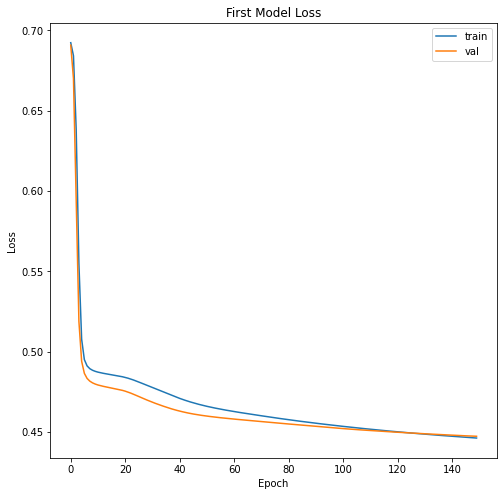

In [11]:
figure(figsize=(8,8)) 
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('First Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

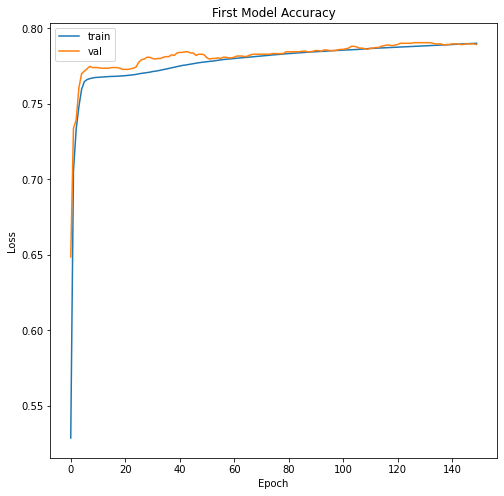

In [12]:
figure(figsize=(8,8)) 
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title('First Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

####As you can see there is neither **overfitting** nor **underfitting**, while the training and validation loss decreases to a point of stability with a minimal gap between the two final loss values. I noticed that if I continued with more epochs the plot of training loss continues to decrease with experience and the plot of validation loss decreases to a point and begins increasing again (which means that we have the phenomenon of overfitting). So I decide to stop to 150 epochs as we have a **good fit**.
---
####If you look carefully, you can see that the model converges approximately in epoch 120. So the **first model** needs at least 120 epochs to reach the minimun cost of 0.45. We should remember this in order to compare this with the other models.


## *Step 9*: Calculate the accuracy on test set  

Here I calculate the accuracy on test set manually and also show the classification report. 

In [13]:
tfidfX_test = tfidfX_test.to(device)
Y_test = Y_test.to(device)

# Forward pass to get output
test_prediction = first_model.forward(tfidfX_test.float())
test_prediction = torch.squeeze(test_prediction)

#Calculate accuracy on test set
test_accuracy = calculate_accuracy(Y_test,test_prediction)

print("Test Accuracy:",round(test_accuracy.item(),4), "\n")

Test Accuracy: 0.7924 



In [14]:
#Show the classification report
test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
Y_test = Y_test.cpu()

print(classification_report(Y_test,test_prediction))

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      1281
         1.0       0.79      0.77      0.78      1219

    accuracy                           0.79      2500
   macro avg       0.79      0.79      0.79      2500
weighted avg       0.79      0.79      0.79      2500



In [15]:
#Close the pickle files.
x_train_file.close()
y_train_file.close()
x_test_file.close()
y_test_file.close()
x_val_file.close()
y_val_file.close()

## *Step 10*: Summaries

- We notice that the first model gives score of 0.79. In order to reach to this score, without overfitting or underfitting, it needed at least 120 epochs to reach the minimun cost.

- The weight decay parameter adds a L2 penalty to the cost which can effectively lead to to smaller model weights. This helped me mainly with overfitting.

- I would like to refer that I experimented with several values of hidden layers and units and I end up to 2 hidden layers with 512 hidden units each. I preffered to start with a non deep Neural Network. For this reason, I select just one layer at the beggining, but this leads me to underfitting and I couldn't fix it easily, so I don't think it was worth mentioning as another model.

- When I have overfitting I tried the technique of Dropout and Batch Normalization but it didn't help me, because the only thing that happened is the cost fluctuate over the training examples and it wasn't so quite smooth just like now.

- I have to mention that in order to run all the colab notebook with no crashed memory, I have to load the half of our dataset, ie 500.000 tweets.